In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import pdb
import copy
import math

from FlowModels import *
from SOBI import *

from sklearn import cluster, datasets, mixture

import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

%matplotlib inline

### Data generation

In [2]:
import scipy as sp
from scipy import signal

np.random.seed(0)
n_samples = 4000
time = np.linspace(0, 8, n_samples)

s1 = np.sin(2 * time)  # Signal 1 : sinusoidal signal

irregular_time = [0]
for _ in time[1:]:
    irregular_time.append(irregular_time[-1] + np.random.randint(5) + 1)
    
irregular_time = np.array(irregular_time) / n_samples * 8

s2 = np.sign(np.sin(3 * irregular_time))  # Signal 2 : square signal

irregular_time = [0]
for _ in time[1:]:
    irregular_time.append(irregular_time[-1] + np.random.randint(5) + 1)
    
irregular_time = np.array(irregular_time) / n_samples * 8

s3 = signal.sawtooth(2 * np.pi * irregular_time)  # Signal 3: saw tooth signal
s4 = np.arange(-1, 1, 2/n_samples)

S = np.c_[s1, s2, s3, s4]
S += 0.2 * np.random.normal(size=S.shape)  # Add noise

S /= S.std(axis=0)  # Standardize data
S = (S - S.min(axis=0, keepdims=True)) / (S.max(axis=0, keepdims=True) - S.min(axis=0, keepdims=True))  # Standardize data
# Mix data
A = np.array([[1, 1, 1, 1], [0.5, 2, 1.0, 0.5], [1.5, 1.0, 2.0, 1.5], [-0.5, 1, 0.2, 0.5]])  # Mixing matrix
X = np.dot(S, A.T)  # Generate observations

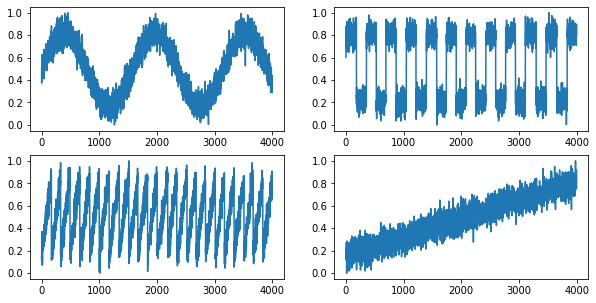

In [3]:
plt.figure(figsize=(10,5))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.plot(S[:, i])

### Non-linear mixing with a randomly initialized flow-based model

In [4]:
D = 4
NN = lambda: nn.Sequential(nn.Linear(D//2, D))

mixture = FlowModel(D, NN, 10).to(device)

S = torch.FloatTensor(S).to(device)
X = torch.FloatTensor(X).to(device)

previous_loss = torch.zeros(X.size(0)).to(device)
    
X_nl = mixture.to_embedding(S, previous_loss)[0].cpu().detach().numpy()

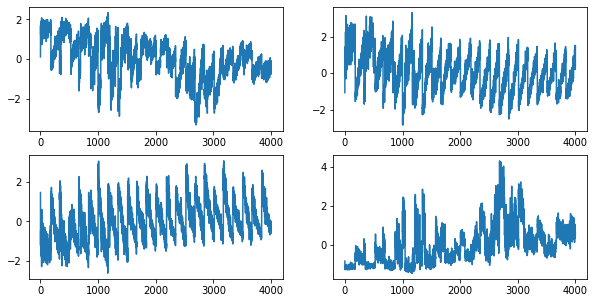

In [5]:
plt.figure(figsize=(10,5))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.plot(X_nl[:, i])

### Test linear ICA to see that it fails

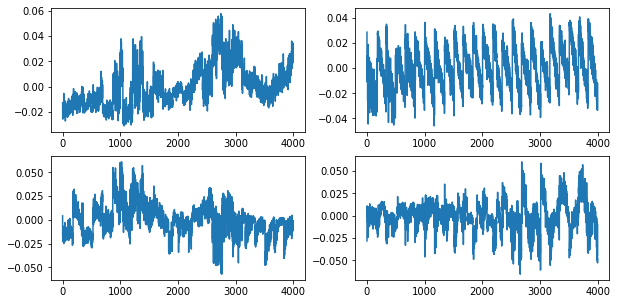

In [6]:
S_estimated = ICA(X_nl.T, lag=50)
S_estimated = S_estimated.T

plt.figure(figsize=(10,5))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.plot(S_estimated[:, i])

In [7]:
previous_loss = torch.zeros(X.size(0)).to(device)
results= []

for _ in range(20):
    mixture = FlowModel(D, NN, 10).to(device)
    X_nl = mixture.to_embedding(S, previous_loss)[0].cpu().detach().numpy()
    S_estimated = ICA(X_nl.T, lag=50)
    results.append(np.abs(np.corrcoef(S.detach().numpy().T, S_estimated)[4:, :-4]).max(1).mean())
    
print(np.mean(results), np.std(results))

0.5908618920932032 0.09321167369990527


We see that the mixing is effectively **not** linearly identifiable. 

### Unmixing with slow-FBM

We first define the flow-based unmixing model

In [8]:
class FlowModel(LayerList, nn.Module):
    
    """ **FlowModel**: example of flow-based model architecture class.
    
        Parameters
        ----------
            * D: dimension of the input
            * NN: neural networks used in the **AffineCoupling**
            * depth: depth of the flow-based model (number of FlowLayers)
            * trainable_variance: possibility to learn the variance parameters of the increment Gaussian distribution
                                  We remind that the theoretical results assume infinte data.
                                  In this toy example, we have not infinte data at all.
                                  The trainable variance for increment distribution gives more robust results in low data setup.
    """
    
    def __init__(self, D, NN, depth=1, trainable_variance=True):
        super(FlowModel, self).__init__()
        self.D = D
        self.depth = depth
        
        if trainable_variance:
            self.scales = nn.ParameterList([nn.Parameter(torch.ones(D), requires_grad=(i!=0)) for i in range(2)])
        else:
            self.scales = nn.ParameterList([nn.Parameter(torch.ones(D), requires_grad=False) for i in range(2)])
        
        layers = []
        for d in range(depth):
            shuffled_layer = Shuffle(D)
            layers.append(shuffled_layer)
            layers.append(ActivationNormalization(D))
            layers.append(AffineCoupling(D, NN()))
            layers.append(shuffled_layer)
            layers.append(ActivationNormalization(D))
            layers.append(AffineCoupling(D, NN()))
        
        layers.append(Linear(D))
        self.layers = nn.ModuleList(layers)

Instanciate the unmixing model

In [9]:
D = 4

NN = lambda: nn.Sequential(nn.Linear(D//2, 16), nn.LeakyReLU(), 
                           nn.Linear(16, D))

flowModel = FlowModel(D, NN, 12)
flowModel = flowModel.to(device)
optimizer = torch.optim.Adam(list(flowModel.parameters()), lr=1e-3)

In [10]:
X_nl = torch.FloatTensor(X_nl).to(device)
previous_loss = torch.zeros(X_nl.size(0)).to(device)
index = np.arange(X_nl.shape[0])

The previous loss is specific to the Abstract Class design of the FlowBased model.

In [11]:
from torch.distributions.multivariate_normal import MultivariateNormal

for t in range(1500):
    
    optimizer.zero_grad()
    
    index = index[::-1]
    
    x = X_nl[list(index)]
    
    previous_loss = torch.zeros(x.size(0)).to(device)
    z, logprob = flowModel.to_embedding(x, previous_loss)
    
    loss = -logprob.mean()
    
    for i, s in enumerate(flowModel.scales):
        s = s**2
        m = MultivariateNormal(torch.zeros(1, D).to(device), torch.diag(s))
        if i == 0:
            z_lag = z
        else:
            z_lag = z[i:] - z[:-i]
        loss -= m.log_prob(z_lag).mean()
        
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        flowModel.layers[-1].W.div_(torch.norm(flowModel.layers[-1].W))
    
    if t % 10 == 0:
        print('iter %s:' % t, 'loss = %.3f' % loss)

iter 0: loss = 11.672
iter 10: loss = 17.046
iter 20: loss = 15.839
iter 30: loss = 14.841
iter 40: loss = 14.165
iter 50: loss = 13.644
iter 60: loss = 13.210
iter 70: loss = 12.856
iter 80: loss = 12.561
iter 90: loss = 12.305
iter 100: loss = 12.083
iter 110: loss = 11.898
iter 120: loss = 11.716
iter 130: loss = 11.556
iter 140: loss = 11.425
iter 150: loss = 11.280
iter 160: loss = 11.162
iter 170: loss = 11.044
iter 180: loss = 10.942
iter 190: loss = 10.844
iter 200: loss = 10.757
iter 210: loss = 10.672
iter 220: loss = 10.578
iter 230: loss = 10.512
iter 240: loss = 10.440
iter 250: loss = 10.379
iter 260: loss = 10.307
iter 270: loss = 10.236
iter 280: loss = 10.180
iter 290: loss = 10.111
iter 300: loss = 10.049
iter 310: loss = 9.982
iter 320: loss = 9.926
iter 330: loss = 9.852
iter 340: loss = 9.790
iter 350: loss = 9.710
iter 360: loss = 9.643
iter 370: loss = 9.589
iter 380: loss = 9.486
iter 390: loss = 9.414
iter 400: loss = 9.334
iter 410: loss = 9.255
iter 420: loss

Plot the estimated sources

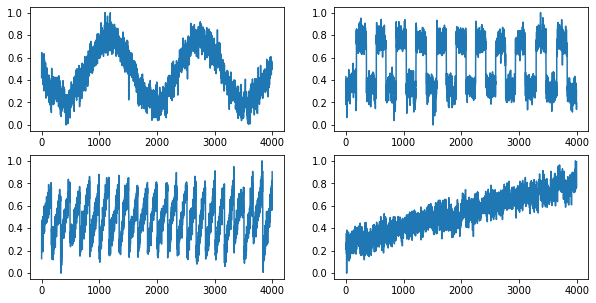

In [25]:
z, logprob = flowModel.to_embedding(X_nl, previous_loss)
S_estimated = ICA(z.detach().numpy().T, lag=100)

m = S_estimated.min(1, keepdims=True)
M = S_estimated.max(1, keepdims=True)
S_estimated = ((S_estimated - m) / (M - m)).T

max_cor = np.argmax(np.abs(np.corrcoef(S.detach().numpy().T, S_estimated.T)[4:, :-4]), axis=0)

plt.figure(figsize=(10,5))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.plot(S_estimated[:, max_cor[i]])

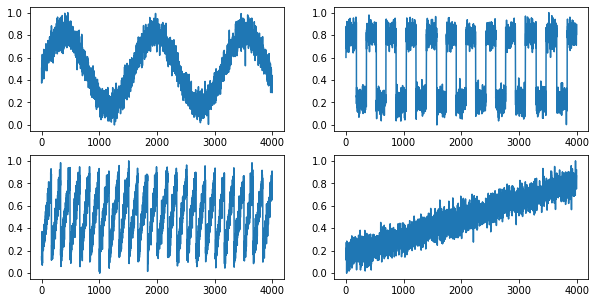

In [24]:
plt.figure(figsize=(10,5))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.plot(S[:, i])

Correlation with the true sources

In [14]:
np.corrcoef(S.detach().numpy().T, S_estimated.T)[4:, :-4]

array([[-0.96853282, -0.02726153, -0.00242191, -0.04433033],
       [ 0.00844358,  0.03216257,  0.95031671,  0.00775819],
       [ 0.03276156, -0.97557633, -0.00259808, -0.03915367],
       [-0.06437548, -0.01774858,  0.02255901,  0.97887625]])

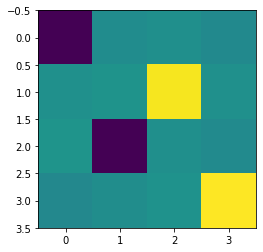

In [16]:
plt.imshow(np.corrcoef(S.detach().numpy().T, S_estimated.T)[4:, :-4])

Mean absolute correlation

In [21]:
np.abs(np.corrcoef(S.detach().numpy().T, S_estimated.T)[4:, :-4]).max(1).mean()

0.9683255298258856